# Leveraging Bellwether Counties for National Election Forecasting with Random Forest

In [10]:
import pandas as pd

In [11]:
# read in data files
county_results = pd.read_csv("https://raw.githubusercontent.com/Efws777/522FP/refs/heads/main/countypres_2000-2020.csv")
county_demos = pd.read_csv("https://raw.githubusercontent.com/Efws777/522FP/refs/heads/main/county_demographics.csv")

## 1. Gather historical election and demographic data for each bellwether county.

In [12]:
# filter county_results to include only the bellwether counties
bellwether_counties = ["BLAINE", "ESSEX", "PINELLAS", "NICOLLET", "SULLIVAN", "ALBANY", "MERCED", "SAN BERNARDINO", "SAN JOAQUIN", "STANISLAUS", "WINNEBAGO", "BREMER", "CORTLAND", "ESSEX", "HIDALGO", "JUNEAU", "MARQUETTE", "OTSEGO", "OTTAWA", "RICHLAND", "SAWYER", "SHIAWASSEE", "VALENCIA", "VAN BUREN", "VIGO", "WARREN", "WASHINGTON", "WESTMORELAND", "WOOD", "CLALLAM"]
assoc_states = ["MONTANA", "NEW YORK", "FLORIDA", "MINNESOTA", "NEW HAMPSHIRE", "WYOMING", "CALIFORNIA", "CALIFORNIA", "CALIFORNIA", "CALIFORNIA", "ILLINOIS", "IOWA", "NEW YORK", "VERMONT", "NEW MEXICO", "WISCONSIN", "WISCONSIN", "NEW YORK", "OHIO", "WISCONSIN", "WISCONSIN", "MICHIGAN", "NEW MEXICO", "MICHIGAN", "INDIANA", "ILLINOIS", "MAINE", "VIRGINIA", "OHIO", "WASHINGTON"]

county_state_pairs = pd.DataFrame({
    'county_name': bellwether_counties,
    'state': assoc_states
})

# merge with county_results to only keep the bellwether counties
bellwether_results = pd.merge(county_results, county_state_pairs, on=['county_name', 'state'])
# filter out non-democrat and non-republican parties
bellwether_results = bellwether_results[bellwether_results['party'].isin(["DEMOCRAT", "REPUBLICAN"])]

# reduce irregular county results to two rows each
bremer_rows = bellwether_results[
    (bellwether_results['county_name'] == "BREMER") &
    (bellwether_results['state'] == "IOWA") &
    (bellwether_results['year'] == 2020)
]

westmoreland_rows = bellwether_results[
    (bellwether_results['county_name'] == "WESTMORELAND") &
    (bellwether_results['state'] == "VIRGINIA") &
    (bellwether_results['year'] == 2020)
]

# set the column name for votes
votes_column = 'candidatevotes'

# get a list of all columns except 'candidatevotes'
non_numeric_columns = [col for col in bremer_rows.columns if col != votes_column]

non_numeric_columns_westmoreland = [col for col in westmoreland_rows.columns if col != votes_column]

# sum votes by party for bremer and westmoreland
combined_bremer = bremer_rows.groupby('party', as_index=False)[votes_column].sum()

combined_westmoreland = westmoreland_rows.groupby('party', as_index=False)[votes_column].sum()

# keep the other non-vote columns
for col in non_numeric_columns:
    combined_bremer[col] = bremer_rows.groupby('party')[col].first().values
    combined_westmoreland[col] = westmoreland_rows.groupby('party')[col].first().values

# remove the old bremer data for 2020
bellwether_results = bellwether_results[
    ~((bellwether_results['county_name'] == "BREMER") &
      (bellwether_results['state'] == "IOWA") &
      (bellwether_results['year'] == 2020))
]

bellwether_results = bellwether_results[
    ~((bellwether_results['county_name'] == "WESTMORELAND") &
      (bellwether_results['state'] == "VIRGINIA") &
      (bellwether_results['year'] == 2020))
]

# add the updated bremer and westmoreland rows back to the data
bellwether_results = pd.concat([bellwether_results, combined_bremer], ignore_index=True)
bellwether_results = pd.concat([bellwether_results, combined_westmoreland], ignore_index=True)

bellwether_results.iloc[-4, bellwether_results.columns.get_loc('mode')] = 'TOTAL'
bellwether_results.iloc[-3, bellwether_results.columns.get_loc('mode')] = 'TOTAL'
bellwether_results.iloc[-2, bellwether_results.columns.get_loc('mode')] = 'TOTAL'
bellwether_results.iloc[-1, bellwether_results.columns.get_loc('mode')] = 'TOTAL'

# reset the index of the dataframe
bellwether_results = bellwether_results.reset_index(drop=True)
bellwether_results = bellwether_results.rename(columns={'totalvotes': 'total_votes'})

# pivot the dataframe to have one row per county with separate columns for democrat and republican votes
pivoted_results = bellwether_results.pivot_table(
    index=['year', 'county_fips', 'county_name', 'state', 'total_votes'],
    columns='party',
    values='candidatevotes',
    aggfunc='first'
).reset_index()

# clean up column names
pivoted_results.columns.name = None  # remove the multi-level column name
pivoted_results = pivoted_results.rename(columns={"DEMOCRAT": "democrat_votes", "REPUBLICAN": "republican_votes"})

# convert county_fips to integer type
pivoted_results['county_fips'] = pivoted_results['county_fips'].astype(int)

# determine the winner based on the votes
pivoted_results['winner'] = pivoted_results.apply(lambda row: 'DEM' if row['democrat_votes'] > row['republican_votes'] else 'REP', axis=1)

# merge the results with county demographic data
results_demo = pd.merge(pivoted_results, county_demos, left_on=['county_fips', 'year'], right_on=['fips', 'year'])
# drop the fips column from the results
results_demo = results_demo.drop('fips', axis=1)



results_demo

,year,county_fips,county_name,state,total_votes,democrat_votes,republican_votes,winner,population,w_population,b_population,o_population,nh_population,hi_population,na_population,male_population,female_population,age0_population,age1_population,age2_population,age3_population,age4_population,age5_population,age6_population,age7_population,age8_population,age9_population,age10_population,age11_population,age12_population,age13_population,age14_population,age15_population,age16_population,age17_population,age18_population,w_population_ratio,b_population_ratio,o_population_ratio,nh_population_ratio,hi_population_ratio,na_population_ratio,male_population_ratio,female_population_ratio,age0_population_ratio,age1_population_ratio,age2_population_ratio,age3_population_ratio,age4_population_ratio,age5_population_ratio,age6_population_ratio,age7_population_ratio,age8_population_ratio,age9_population_ratio,age10_population_ratio,age11_population_ratio,age12_population_ratio,age13_population_ratio,age14_population_ratio,age15_population_ratio,age16_population_ratio,age17_population_ratio,age18_population_ratio
0,2000,6047,MERCED,CALIFORNIA,50418,22726,26102,REP,212258,182019,9481,3892,115590,96668,0,105855,106403,3653,15157,21306,20868,19408,14780,13935,14528,15676,14881,12632,10539,8084,6711,6052,5095,4160,2678,2115,0.85754,0.04467,0.01834,0.54457,0.45543,0.0,0.49871,0.50129,0.01721,0.07141,0.10038,0.09831,0.09144,0.06963,0.06565,0.06845,0.07385,0.07011,0.05951,0.04965,0.03809,0.03162,0.02851,0.02400,0.01960,0.01262,0.00996
1,2000,6071,SAN BERNARDINO,CALIFORNIA,454893,214749,221757,REP,1718037,1416843,173089,29366,1041665,676372,0,857474,860563,27722,115928,163604,159513,141833,122738,117718,125752,139110,134485,113592,92173,65924,50872,43326,38096,31110,19180,15361,0.82469,0.10075,0.01709,0.60631,0.39369,0.0,0.49910,0.50090,0.01614,0.06748,0.09523,0.09285,0.08256,0.07144,0.06852,0.07320,0.08097,0.07828,0.06612,0.05365,0.03837,0.02961,0.02522,0.02217,0.01811,0.01116,0.00894
2,2000,6077,SAN JOAQUIN,CALIFORNIA,167239,79776,81773,REP,567885,439219,42711,9124,393303,174582,0,283881,284004,8715,36604,50613,50445,48271,38203,36302,39620,44177,42925,37507,32068,23961,18439,15765,14951,13093,8670,7556,0.77343,0.07521,0.01607,0.69258,0.30742,0.0,0.49989,0.50011,0.01535,0.06446,0.08913,0.08883,0.08500,0.06727,0.06392,0.06977,0.07779,0.07559,0.06605,0.05647,0.04219,0.03247,0.02776,0.02633,0.02306,0.01527,0.01331
3,2000,6099,STANISLAUS,CALIFORNIA,128267,56448,67188,REP,449471,402198,14153,7994,305869,143602,0,221239,228232,6854,28914,40191,40621,37280,30397,29563,31395,35102,34054,29615,25197,18705,14709,12855,11587,9995,6589,5848,0.89483,0.03149,0.01779,0.68051,0.31949,0.0,0.49222,0.50778,0.01525,0.06433,0.08942,0.09038,0.08294,0.06763,0.06577,0.06985,0.07810,0.07576,0.06589,0.05606,0.04162,0.03273,0.02860,0.02578,0.02224,0.01466,0.01301
4,2000,12103,PINELLAS,FLORIDA,398472,200630,184825,DEM,922150,810830,86167,3387,878724,43426,0,439429,482721,8976,36305,50516,51882,47476,41756,50198,57841,70565,72826,67190,63095,51431,45263,46399,49505,46159,33818,30949,0.87928,0.09344,0.00367,0.95291,0.04709,0.0,0.47653,0.52347,0.00973,0.03937,0.05478,0.05626,0.05148,0.04528,0.05444,0.06272,0.07652,0.07897,0.07286,0.06842,0.05577,0.04908,0.05032,0.05368,0.05006,0.03667,0.03356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2020,55057,JUNEAU,WISCONSIN,13709,4746,8749,REP,26908,25453,768,495,26039,869,0,14308,12600,253,1111,1444,1563,1460,1300,1586,1443,1613,1583,1691,1807,2143,2164,1887,1500,1089,654,617,0.94593,0.02854,0.01840,0.96770,0.03230,0.0,0.53174,0.46826,0.00940,0.04129,0.05366,0.05809,0.05426,0.04831,0.05894,0.05363,0.05994,0.05883,0.06284,0.06715,0.07964,0.08042,0.07013,0.05575,0.04047,0.02431,0.02293
176,2020,55077,MARQUETTE,WISCONSIN,9065,32

In [13]:
results_demo['winner'].value_counts()

,count
winner,
REP,101
DEM,79


# 2. Create historical voting trend features.

## Historical Voting trend features:
*   Cumulative average voting ratios
*   Voter turnout ratio
*   Margin of victory (ratio-based)
*   Population growth ratio since last election year



In [14]:
# --- Cumulative Average Voting Ratios ---
# calculate the democrat and republican vote ratios by dividing votes by total votes
results_demo['democrat_votes_ratio'] = results_demo['democrat_votes'] / results_demo['total_votes']
results_demo['republican_votes_ratio'] = results_demo['republican_votes'] / results_demo['total_votes']

# move the vote ratio columns to appropriate positions in the dataframe
results_demo.insert(7, 'democrat_votes_ratio', results_demo.pop('democrat_votes_ratio'))
results_demo.insert(8, 'republican_votes_ratio', results_demo.pop('republican_votes_ratio'))

# sort data by county and year to ensure proper calculation of cumulative averages
results_demo = results_demo.sort_values(by=['county_fips', 'year'])

# calculate the cumulative average of the democrat and republican vote ratios for each county
results_demo['cum_avg_democrat_ratio'] = results_demo.groupby('county_fips')['democrat_votes_ratio'].expanding().mean().reset_index(level=0, drop=True)
results_demo['cum_avg_republican_ratio'] = results_demo.groupby('county_fips')['republican_votes_ratio'].expanding().mean().reset_index(level=0, drop=True)

# shift the cumulative ratios down by 1 row for each county (to avoid using the current year data for predictions)
results_demo['cum_avg_democrat_ratio'] = (results_demo.groupby('county_fips')['cum_avg_democrat_ratio'].shift(1))
results_demo['cum_avg_republican_ratio'] = (results_demo.groupby('county_fips')['cum_avg_republican_ratio'].shift(1))

# move the cumulative ratio columns to appropriate positions in the dataframe
results_demo.insert(9, 'cum_avg_democrat_ratio', results_demo.pop('cum_avg_democrat_ratio'))
results_demo.insert(10, 'cum_avg_republican_ratio', results_demo.pop('cum_avg_republican_ratio'))


# --- Voter Turnout Ratio ---
# calculate the voter turnout ratio by dividing total votes by population
results_demo['turnout_ratio'] = results_demo['total_votes'] / results_demo['population']

# move the turnout ratio column to the 5th position in the dataframe
results_demo.insert(5, 'turnout_ratio', results_demo.pop('turnout_ratio'))

# calculate the cumulative average of the turnout ratio for each county
results_demo['cum_avg_turnout_ratio'] = (results_demo.groupby('county_fips')['turnout_ratio'].expanding().mean().reset_index(level=0, drop=True))

# shift the cumulative turnout ratio down by 1 row for each county (to avoid using the current year data for predictions)
results_demo['cum_avg_turnout_ratio'] = (results_demo.groupby('county_fips')['cum_avg_turnout_ratio'].shift(1))

# move the cumulative turnout ratio to the 6th position in the dataframe
results_demo.insert(6, 'cum_avg_turnout_ratio', results_demo.pop('cum_avg_turnout_ratio'))


# --- Margin of Victory (Ratio-Based) ---
# calculate the margin of victory by subtracting the republican vote ratio from the democrat vote ratio
results_demo['dem_ratio_minus_rep_ratio'] = results_demo['democrat_votes_ratio'] - results_demo['republican_votes_ratio']

# calculate the cumulative average of the margin of victory for each county
results_demo['cum_avg_dem_ratio_minus_rep_ratio'] = results_demo.groupby('county_fips')['dem_ratio_minus_rep_ratio'].expanding().mean().reset_index(level=0, drop=True)

# shift the cumulative margin of victory down by 1 row for each county
results_demo['cum_avg_dem_ratio_minus_rep_ratio'] = results_demo.groupby('county_fips')['cum_avg_dem_ratio_minus_rep_ratio'].shift(1)

# move the margin of victory and its cumulative average to appropriate positions in the dataframe
results_demo.insert(11, 'dem_ratio_minus_rep_ratio', results_demo.pop('dem_ratio_minus_rep_ratio'))
results_demo.insert(14, 'cum_avg_dem_ratio_minus_rep_ratio', results_demo.pop('cum_avg_dem_ratio_minus_rep_ratio'))


# --- Population Growth Ratio Since Last Election Year ---
# calculate the year-to-year percentage change in population for each county
results_demo['pop_pct_change'] = (results_demo.groupby('county_fips')['population'].pct_change())

# calculate the cumulative average of the population percentage change for each county
results_demo['cum_avg_pop_change'] = results_demo.groupby('county_fips')['pop_pct_change'].expanding().mean().reset_index(level=0, drop=True)

# move the population percentage change and its cumulative average to appropriate positions in the dataframe
results_demo.insert(17, 'pop_pct_change', results_demo.pop('pop_pct_change'))
results_demo.insert(18, 'cum_avg_pop_change', results_demo.pop('cum_avg_pop_change'))

# drop certain columns to prepare for random forest input
results_demo = results_demo.drop(results_demo.columns[1:4], axis=1)
results_demo = results_demo.drop(results_demo.columns[1:3], axis=1)
results_demo = results_demo.drop(results_demo.columns[2:7], axis=1)
results_demo = results_demo.drop(results_demo.columns[7], axis=1)
results_demo = results_demo.drop(results_demo.columns[8:35], axis=1)
results_demo = results_demo.drop(results_demo.columns[13], axis=1)

# --- Special Handling for Year 2000 ---
# for year 2000, fill the cumulative averages with the value from 2004 (to handle NaNs)
results_demo.loc[results_demo['year'] == 2000, 'cum_avg_turnout_ratio'] = results_demo.loc[results_demo['year'] == 2004, 'cum_avg_turnout_ratio'].values
results_demo.loc[results_demo['year'] == 2000, 'cum_avg_democrat_ratio'] = results_demo.loc[results_demo['year'] == 2004, 'cum_avg_democrat_ratio'].values
results_demo.loc[results_demo['year'] == 2000, 'cum_avg_republican_ratio'] = results_demo.loc[results_demo['year'] == 2004, 'cum_avg_republican_ratio'].values
results_demo.loc[results_demo['year'] == 2000, 'cum_avg_dem_ratio_minus_rep_ratio'] = results_demo.loc[results_demo['year'] == 2004, 'cum_avg_dem_ratio_minus_rep_ratio'].values

pd.set_option('display.max_columns', None)
results_demo


,year,cum_avg_turnout_ratio,cum_avg_democrat_ratio,cum_avg_republican_ratio,cum_avg_dem_ratio_minus_rep_ratio,winner,population,cum_avg_pop_change,w_population_ratio,b_population_ratio,o_population_ratio,nh_population_ratio,hi_population_ratio,male_population_ratio,female_population_ratio,age0_population_ratio,age1_population_ratio,age2_population_ratio,age3_population_ratio,age4_population_ratio,age5_population_ratio,age6_population_ratio,age7_population_ratio,age8_population_ratio,age9_population_ratio,age10_population_ratio,age11_population_ratio,age12_population_ratio,age13_population_ratio,age14_population_ratio,age15_population_ratio,age16_population_ratio,age17_population_ratio,age18_population_ratio
0,2000,0.237532,0.450752,0.517712,-0.066960,REP,212258,NaN,0.85754,0.04467,0.01834,0.54457,0.45543,0.49871,0.50129,0.01721,0.07141,0.10038,0.09831,0.09144,0.06963,0.06565,0.06845,0.07385,0.07011,0.05951,0.04965,0.03809,0.03162,0.02851,0.02400,0.01960,0.01262,0.00996
30,2004,0.237532,0.450752,0.517712,-0.066960,REP,237180,0.117414,0.85444,0.04596,0.02078,0.49579,0.50421,0.50231,0.49769,0.01767,0.07074,0.08730,0.10013,0.09276,0.07706,0.06772,0.06821,0.06903,0.07078,0.06340,0.05222,0.04275,0.03289,0.02649,0.02145,0.01690,0.01263,0.00987
60,2008,0.240920,0.436706,0.541650,-0.104944,DEM,250538,0.086867,0.84323,0.04824,0.02439,0.46138,0.53862,0.50326,0.49674,0.01803,0.07120,0.08430,0.09078,0.09637,0.07761,0.07112,0.06476,0.06644,0.06375,0.06489,0.05696,0.04638,0.03746,0.02782,0.02163,0.01684,0.01229,0.01137
90,2012,0.245508,0.468915,0.511050,-0.042135,DEM,260776,0.071533,0.83535,0.04868,0.02778,0.43785,0.56215,0.50423,0.49577,0.01645,0.06649,0.08647,0.08461,0.08863,0.08433,0.07151,0.06758,0.06122,0.06112,0.06034,0.05898,0.05091,0.04208,0.03261,0.02341,0.01773,0.01295,0.01257
120,2016,0.243624,0.484649,0.494399,-0.009750,DEM,267370,0.059971,0.83646,0.04669,0.02795,0.41146,0.58854,0.50350,0.49650,0.01532,0.06418,0.08492,0.08436,0.08557,0.07713,0.07700,0.06801,0.06292,0.05842,0.05744,0.05667,0.05394,0.04465,0.03684,0.02683,0.01904,0.01335,0.01342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2004,0.442689,0.358208,0.552187,-0.193979,REP,33580,0.050491,0.95057,0.01459,0.01147,0.92123,0.07877,0.51665,0.48335,0.01129,0.04089,0.04425,0.04485,0.10697,0.24455,0.07326,0.05819,0.04714,0.05083,0.05721,0.06081,0.04655,0.03166,0.02341,0.01986,0.01605,0.01248,0.00977
89,2008,0.468873,0.393162,0.546967,-0.153805,DEM,34643,0.041073,0.94591,0.01498,0.01085,0.91456,0.08544,0.52213,0.47787,0.01137,0.04056,0.04232,0.04136,0.10836,0.22564,0.09716,0.05505,0.04751,0.04437,0.04910,0.05710,0.05323,0.03932,0.02829,0.01983,0.01582,0.01224,0.01137
119,2012,0.478089,0.429618,0.518434,-0.088817,REP,37404,0.053949,0.93423,0.02008,0.01126,0.91135,0.08865,0.52139,0.47861,0.01184,0.04283,0.04540,0.03898,0.08924,0.23393,0.09293,0.06753,0.04786,0.04395,0.04128,0.05072,0.05462,0.04729,0.03312,0.02171,0.01385,0.01126,0.01166
149,2016,0.467512,0.436600,0.509470,-0.072870,REP,38012,0.044525,0.92886,0.02162,0.01302,0.90613,0.09387,0.52373,0.47627,0.00994,0.03857,0.04875,0.04296,0.08176,0.22296,0.09700,0.06703,0.05454,0.04399,0.03993,0.04183,0.05056,0.05125,0.04275,0.02576,0.01784,0.01031,0.01229


# 3. Train a random forest classifier and tune hyperparameters to optimize performance.

In [15]:
# split the data into training (before 2020) and testing (for 2020)
train_data = results_demo[results_demo['year'] < 2020]
test_data = results_demo[results_demo['year'] == 2020]
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# drop unnecessary index column
train_data.drop(train_data.columns[0], axis=1, inplace=True)
test_data.drop(test_data.columns[0], axis=1, inplace=True)

# convert the winner column to numeric (1 for 'DEM' and 0 for 'REP')
train_data['winner'] = train_data['winner'].map({'DEM': 1, 'REP': 0})
test_data['winner'] = test_data['winner'].map({'DEM': 1, 'REP': 0})

# separate the target variable (y) and features (X) for training and testing
y_train = train_data['winner']
X_train = train_data.drop(columns=['winner'])

y_test = test_data['winner']
X_test = test_data.drop(columns=['winner'])

print(X_train.shape)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# set up the parameter grid for RandomizedSearchCV
param_dist = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50, 100, 200, 300]
}

# initialize the random forest classifier
rf = RandomForestClassifier(random_state=77)

# set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    verbose=2,
    random_state=77,
    n_jobs=-1
)

# fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# get the best parameters and training accuracy
best_params = random_search.best_params_
best_train_accuracy = random_search.best_score_

# test the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# print the results
print("Best Parameters:", best_params)
print("Best Training Accuracy:", best_train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

y_pred

(150, 32)
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10, 'bootstrap': True}
Best Training Accuracy: 0.7733333333333333
Test Accuracy: 0.7333333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        18
           1       0.83      0.42      0.56        12

    accuracy                           0.73        30
   macro avg       0.77      0.68      0.68        30
weighted avg       0.76      0.73      0.71        30



array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0])

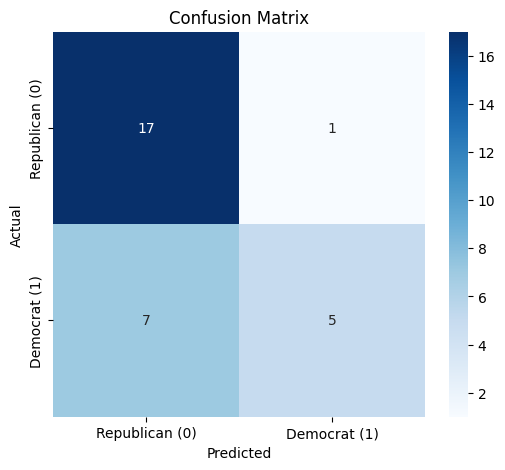

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Republican (0)', 'Democrat (1)'], yticklabels=['Republican (0)', 'Democrat (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()